# Connecting Qiskit Pulse with Qiskit Dynamics

This tutorial shows a simple model of a qubit used to demonstrate how Qiskit Dynamics can simulate the time evolution of a pulse schedule. The qubit is modeled by the drift hamiltonian

\begin{align}
\hat H_\text{drift} = \frac{\omega}{2} Z
\end{align}

to which we apply the drive

\begin{align}
\hat H_\text{drive}(t) = \frac{r\,\Omega(t)}{2} X
\end{align}

Here, $\Omega(t)$ is the drive signal which we will create using Qiskit pulse. The factor $r$ is the strength with which the drive signal drives the qubit. We begin by creating a pulse schedule with a `sx` gate followed by a phase shift on the drive so that the following pulse creates a `sy` rotation. Therefore, if the qubit begins in the ground state we expect that this second pulse will not have any effect on the qubit. This situation is simulated with the following steps:

1. Create the pulse schedule
2. Convert the pulse schedule to a Signal
3. Create the system model
4. Simulate the pulse schedule using the model

## 1. Create the pulse schedule

First, we use the pulse module in Qiskit to create a pulse schedule.

In [1]:
import numpy as np

import qiskit.pulse as pulse

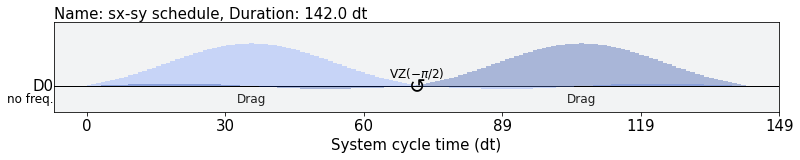

In [2]:
# Strength of the Rabi-rate in GHz.
r = 0.1

# Frequency of the qubit transition in GHz.
w = 5.

# Sample rate of the backend in ns.
dt = 0.222

# Define gaussian envelope function to have a pi rotation.
amp = 1.
area = 1
sig = area*0.399128/r/amp
T = 4*sig
duration = int(T / dt)
beta = 2.0

# The 1.75 factor is used to approximately get a sx gate.
# Further "calibration" could be done to refine the pulse amplitude.
with pulse.build(name="sx-sy schedule") as xp:
    pulse.play(pulse.Drag(duration, amp / 1.75, sig / dt, beta), pulse.DriveChannel(0))
    pulse.shift_phase(np.pi/2, pulse.DriveChannel(0))
    pulse.play(pulse.Drag(duration, amp / 1.75, sig / dt, beta), pulse.DriveChannel(0))
    
xp.draw()

## 2. Convert the pulse schedule to a Signal

To use Qiskit Dynamics we must convert the pulse schedule to instances of `Signal`. This is done using the pulse instruction to signal converter `InstructionToSignals`. This converter needs to know the sample rate of the arbitrary waveform generators creating the signals, i.e. `dt`, as well as the carrier frequency of the signals, i.e. `w`. The plot below shows the envelopes and the signals resulting from this conversion. The dashed line shows the time at which the virtual `Z` gate is applied.

In [3]:
from matplotlib import pyplot as plt

from qiskit_dynamics.pulse import InstructionToSignals

plt.rcParams["font.size"] = 16

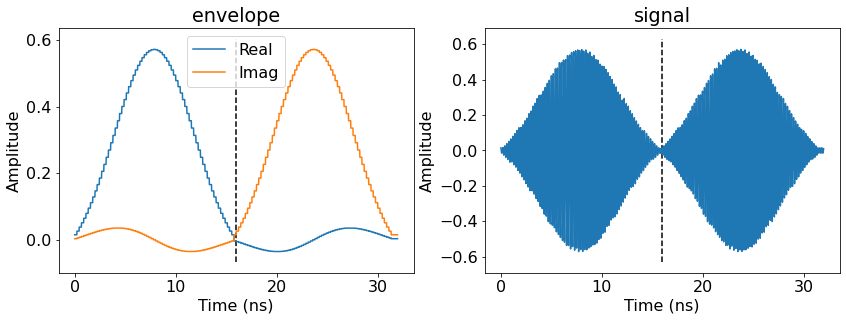

In [4]:
converter = InstructionToSignals(dt, carriers=[w])

signals = converter.get_signals(xp)
fig, axs = plt.subplots(1, 2, figsize=(14, 4.5))
for ax, title in zip(axs, ["envelope", "signal"]):
    signals[0].draw(0, 2*T, 2000, title, axis=ax)
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Amplitude")
    ax.set_title(title)
    ax.vlines(T, ax.get_ylim()[0], ax.get_ylim()[1], "k", linestyle="dashed")

## 3. Create the system model

We now setup the Hamiltonian with the signals as drives, enter the rotating frame and perform the rotating wave approximation.

In [5]:
from qiskit.quantum_info.operators import Operator
from qiskit_dynamics.models import HamiltonianModel, rotating_wave_approximation

In [6]:
# construct operators
X = Operator.from_label('X')
Z = Operator.from_label('Z')

drift = 2 * np.pi * w * Z/2
operators = [2 * np.pi * r * X/2]

# construct model
hamiltonian = HamiltonianModel(drift=drift, operators=operators, signals=signals)

# Perform the RWA approximation
rwa_hamiltonian = rotating_wave_approximation(hamiltonian, 2*w)

## 4. Simulate the pulse schedule using the model

In the last step we perform the simulation and plot the results.

In [7]:
from qiskit.quantum_info.states import Statevector
from qiskit_dynamics import solve_lmde

In [8]:
# Start the qubit in its ground state.
y0 = Statevector([1., 0.])

%time sol = solve_lmde(rwa_hamiltonian, t_span=[0., 2*T], y0=y0, atol=1e-10, rtol=1e-10)

CPU times: user 16.2 s, sys: 8.44 ms, total: 16.2 s
Wall time: 16.2 s


In [9]:
def plot_populations(sol):
    pop0 = np.abs(sol.y[:, 0]) ** 2
    pop1 = np.abs(sol.y[:, 1]) ** 2

    fig = plt.figure(figsize=(8, 5))
    plt.plot(sol.t, pop0, lw=3, label="Population in |0>")
    plt.plot(sol.t, pop1, lw=3, label="Population in |1>")
    plt.xlabel("Time (ns)")
    plt.ylabel("Population")
    plt.legend(frameon=False)
    plt.ylim([0, 1.05])
    plt.xlim([0, 2*T])
    plt.vlines(T, 0, 1.05, "k", linestyle="dashed")

The plot below shows the population of the qubit as it evolves during the pulses. The vertical dashed line shows the time of the virtual Z rotation which was induced by the `shift_phase` instruction in the pulse schedule. As expected, the first pulse moves the qubit to an eigenstate of the `Y` operator. Therefore, the second pulse, which drives around the `Y`-axis due to the phase shift, has hardley any influence on the populations of the qubit.

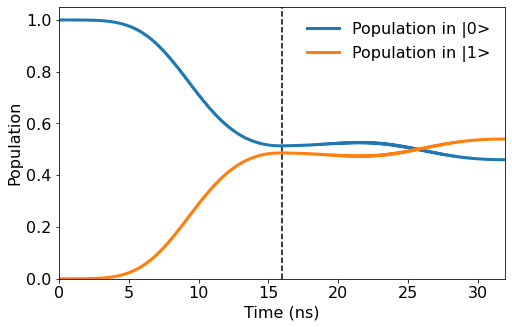

In [10]:
plot_populations(sol)